In [1]:
# copied from viz_bnef_results
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

2020-12-20 09:24:03,073 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/lustre/eaglefs/projects/vapor/vapor-open'

In [3]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results_newtb.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)

In [4]:
# --- Merge on Regions ---
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')


In [5]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]


# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = c_df['value'] / c_df['system_capacity'] * 1000
c_df.drop_duplicates(inplace=True)
c_df.head(5)

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_busbar_energy_value,169.322663,2020,37.627258
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_busbar_energy_value,547.587008,2020,60.843001
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_busbar_energy_value,837.174914,2020,83.717491
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_busbar_energy_value,2276.277843,2020,25.069139
5,p10,rto4,PA,western,West,4776,wind,58800.0,cambium_busbar_energy_value,3001.455462,2020,51.045161


### NOTE: oddity
Results show:
* solar pv typically offsets lower emissions when using lrmer vs avg (_to be expected_)
* wind typically offsets _higher_ emissions using lrmer vs. avg

+ no longer the case, lrmer consistently higher

In [6]:
temp_lrmer = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ].groupby(['inter', 'tech', 'year'], as_index=False)['value'].mean()
temp_avg = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_avg') &\
         (c_df['year'] == 2020)\
        ].groupby(['inter', 'tech', 'year'], as_index=False)['value'].mean()
temp_comb = temp_avg.merge(temp_lrmer, on=['inter', 'tech', 'year'], suffixes=('_avg', '_lrmer'))
temp_comb['perc_diff'] = ((temp_comb['value_avg'] - temp_comb['value_lrmer'])/temp_comb['value_avg'])*100
temp_comb

,inter,tech,year,value_avg,value_lrmer,perc_diff
0,eastern,pv,2020,13040.921018,18466.086474,-41.601091
1,eastern,wind,2020,56147.001519,141686.038755,-152.348362
2,texas,pv,2020,40446.074322,53738.106251,-32.863590
3,texas,wind,2020,23183.103945,49359.469788,-112.911394
4,western,pv,2020,8343.975948,15107.415598,-81.057756
5,western,wind,2020,10696.147098,16027.126143,-49.840181


In [11]:
temp_lrmer = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ]
temp_avg = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_avg') &\
         (c_df['year'] == 2020)\
        ]
merge_cols = ['pca','rto','census_reg','inter','census_div','project_id','tech','system_capacity','year']
temp_comb = temp_avg.drop(columns=['variable', 'value_mw']).merge(temp_lrmer.drop(columns=['variable', 'value_mw']), 
                           on= merge_cols, 
                           suffixes=('_avg', '_lrmer'))

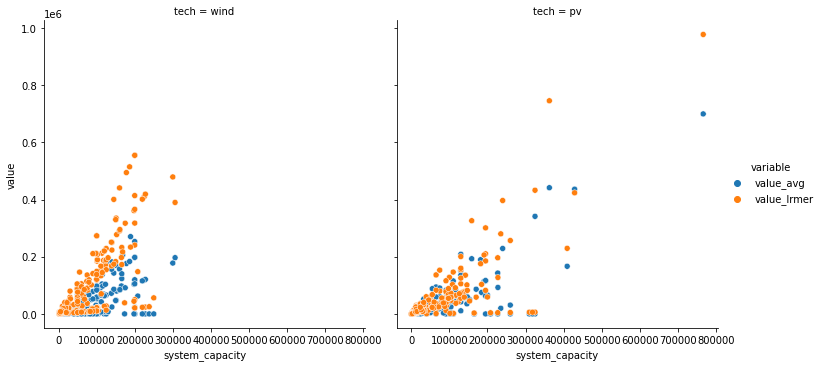

In [12]:
sns.relplot(
    data= temp_comb.melt(id_vars= merge_cols), x="system_capacity", y="value",
    col="tech", hue="variable",kind="scatter"
)
#sns.scatterplot(data=temp_comb.loc[temp_comb.tech=='wind'], x="system_capacity", y="value", hue="variable")

In [9]:
temp_comb['perc_diff'] = (temp_comb['value_avg']/temp_comb['system_capacity'] -\
                          temp_comb['value_lrmer']/temp_comb['system_capacity'])/(temp_comb['value_avg']/temp_comb['system_capacity'])

In [13]:
set(temp_lrmer.year)

{2020}

In [14]:
c_df.head()

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1960.509202,2020,435.668712
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_co2_rate_lrmer,7530.767646,2020,836.751961
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_co2_rate_lrmer,17541.414269,2020,1754.141427
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_co2_rate_lrmer,23465.233437,2020,258.427681
5,p10,rto4,PA,western,West,4776,wind,58800.0,cambium_co2_rate_lrmer,14285.715773,2020,242.954350


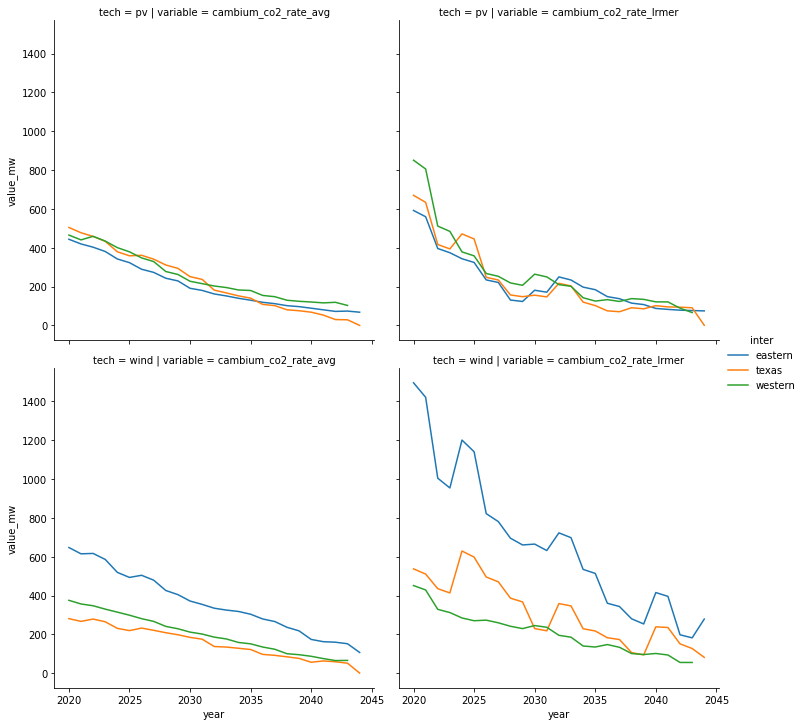

In [8]:
data_temp = c_df.copy().loc[c_df.variable.isin(['cambium_co2_rate_lrmer', 'cambium_co2_rate_avg'])]
data_temp = data_temp.groupby(['year', 'inter', 'tech', 'variable'], as_index=False)['value_mw'].mean()
sns.relplot(x="year", y="value_mw", hue="inter", col="variable", row="tech",
            data=data_temp, 
            kind="line")

In [32]:
data_temp.head(20)

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_lrmer,1960.509202,2020,435.668712
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_co2_rate_lrmer,7530.767646,2020,836.751961
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_co2_rate_lrmer,17541.414269,2020,1754.141427
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_co2_rate_lrmer,23465.233437,2020,258.427681
5,p10,rto4,PA,western,West,4776,wind,58800.0,cambium_co2_rate_lrmer,14285.715773,2020,242.954350
6,p24,rto5,MTN,western,West,4778,wind,29400.0,cambium_co2_rate_lrmer,30229.589720,2020,1028.217337
7,p11,rto4,PA,western,West,5161,pv,900.0,cambium_co2_rate_lrmer,219.726541,2020,244.140601
8,p9,rto4,PA,western,West,5548,pv,4200.0,cambium_co2_rate_lrmer,828.464297,2020,197.253404
9,p63,rto10,WSC,texas,South,6310,wind,5000.0,cambium_co2_rate_lrmer,5203.957639,2020,1040.791528
10,p9,rto4,PA,western,West,6354,pv,1200.0,cambium_co2_rate_lrmer,236.851047,2020,197.375872
